The goal of this notebook is to **analyze the origin-destination data from the NYC Suwbays.** In particular, I am interested in the different classifications of subway stations based on ridership by time of day and week. For instance, stations near lower manhattan will have much different characteristics than stations in south brooklyn (e.g.: Whitehall St (R) vs. 95th st in Bay Ridge (R)).  

# Imports

In [1]:
import pandas as pd 
import os
import calendar 
import datetime
from clustergram import Clustergram
import seaborn
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
import numpy as np

## Functions

In [2]:
def generate_day_number(dataframe: pd.DataFrame, day_of_week_colum='Day of Week'):
    day_mapping = list(calendar.day_name)
    day_number_list = []
    for value in dataframe[day_of_week_colum]:
        new_value = day_mapping.index(value)
        day_number_list.append(new_value)
    dataframe['day_number'] = day_number_list
    return dataframe

def determine_train_time_intervals(arrival_time, day_of_week: str):
    arrival_time = datetime.time(arrival_time)
    train_time_interval = None
    if datetime.time(0, 0) <= arrival_time < datetime.time(6, 30):
        train_time_interval = 'Late Night'
    elif day_of_week in ['Saturday', 'Sunday']:
        train_time_interval = 'Weekend'
    elif datetime.time(6) <= arrival_time < datetime.time(9):
        train_time_interval = 'Rush Hour AM'
    elif datetime.time(9) <= arrival_time < datetime.time(15):
        train_time_interval = 'Midday'
    elif datetime.time(15) <= arrival_time < datetime.time(20, 0):
        train_time_interval = 'Rush Hour PM'
    elif datetime.time(20, 0) <= arrival_time <= datetime.time(23, 59):
        train_time_interval = 'Evening'
    return train_time_interval

def get_total_average_ridership_by_station(dataframe:pd. DataFrame, type_of_trip: str):
    total_ridership_values = []
    for idx in range(len(dataframe)):
        station = dataframe['Station Complex Name'][idx]
        total_ridership = dataframe[dataframe['Station Complex Name']
                                    ==station][f'Estimated Average Ridership - {type_of_trip}'].sum()
        total_ridership_values.append(total_ridership)
    dataframe[f'Estimated Average Ridership - {type_of_trip} - Total'] = total_ridership_values
    return dataframe
def find_ratio_diff_to_mean(df: pd.DataFrame, destination_origin_str: str):
    median_o_d_ratios = df.groupby('time_interval')[f'{destination_origin_str} Interval Ridership Ratio'].median()
    o_d_ratio_diff_list = []
    for idx in range(len(df)):
        ratio_diff = round(float(df[f'{destination_origin_str} Interval Ridership Ratio'][idx] - median_o_d_ratios[df['time_interval'][idx]]), 2)
        o_d_ratio_diff_list.append(ratio_diff)
    df[f'{destination_origin_str}_ratio_diff'] = o_d_ratio_diff_list
    return df

## Data Imports

In [3]:
origin_df = pd.read_csv("./transformed_data/origin_data_transformed.csv", index_col=0)
destination_df = pd.read_csv("./transformed_data/destination_data_transformed.csv", index_col=0)
station_names_df = pd.read_csv("./transformed_data/station_names_transformed.csv", index_col=0)

### Transformations

In [4]:
# Adding the station names
origin_df = origin_df.merge(station_names_df[['Station Complex ID', 'Station Complex Name']]
                     , left_on='Origin Station Complex ID', right_on='Station Complex ID')
origin_df = origin_df.drop(columns=['Station Complex ID'])
destination_df = destination_df.merge(station_names_df[['Station Complex ID', 'Station Complex Name']]
                     , left_on='Destination Station Complex ID', right_on='Station Complex ID')
destination_df = destination_df.drop(columns=['Station Complex ID'])

In [5]:
# # making day names to day numbers 
# origin_df = generate_day_number(origin_df)
# destination_df = generate_day_number(destination_df)

In [6]:
# interval names 
interval_list_origin = [determine_train_time_intervals(origin_df['Hour of Day'][idx], 
                                                origin_df['Day of Week'][idx]) 
                                                for idx in range(len(origin_df))]
origin_df['time_interval'] = interval_list_origin
interval_list_destination = [determine_train_time_intervals(destination_df['Hour of Day'][idx], 
                                                destination_df['Day of Week'][idx]) 
                                                for idx in range(len(destination_df))]
destination_df['time_interval'] = interval_list_destination

In [7]:
# group by interval 
origin_df_interval = origin_df.groupby(['Station Complex Name'
                                        , 'time_interval'])['Estimated Average Ridership'].sum().reset_index()
origin_df_interval.columns = ['Station Complex Name', 'time_interval', 'Estimated Average Ridership - Origin']
destination_df_interval = destination_df.groupby(['Station Complex Name'
                                        , 'time_interval'])['Estimated Average Ridership'].sum().reset_index()
destination_df_interval.columns = ['Station Complex Name', 'time_interval', 'Estimated Average Ridership - Destination']

In [8]:
# Jefferson St 
# destination_df_interval[destination_df_interval['Station Complex Name'].str.contains("Jefferson")]
# origin_df_interval[origin_df_interval['Station Complex Name'].str.contains("Jefferson")]

In [9]:
# add total ridership to df for each station 
origin_df_interval = get_total_average_ridership_by_station(origin_df_interval, 'Origin')
origin_df_interval['Origin Interval Ridership Ratio'] = round(origin_df_interval['Estimated Average Ridership - Origin']
                                                              / origin_df_interval['Estimated Average Ridership - Origin - Total'], 2)
destination_df_interval = get_total_average_ridership_by_station(destination_df_interval, 'Destination')
destination_df_interval['Destination Interval Ridership Ratio'] = round(destination_df_interval['Estimated Average Ridership - Destination']
                                                              / destination_df_interval['Estimated Average Ridership - Destination - Total'], 2)

In [10]:
# full interval dataframe
full_interval_df = origin_df_interval.merge(destination_df_interval, on=['Station Complex Name', 'time_interval'])
full_interval_df = find_ratio_diff_to_mean(full_interval_df, "Destination")
full_interval_df = find_ratio_diff_to_mean(full_interval_df, "Origin")
full_interval_df.head()

,Station Complex Name,time_interval,Estimated Average Ridership - Origin,Estimated Average Ridership - Origin - Total,Origin Interval Ridership Ratio,Estimated Average Ridership - Destination,Estimated Average Ridership - Destination - Total,Destination Interval Ridership Ratio,Destination_ratio_diff,Origin_ratio_diff
0,1 Av (L),Evening,14126.571429,111844.428571,0.13,10994.857143,112912.0,0.10,0.00,0.08
1,1 Av (L),Late Night,4824.857143,111844.428571,0.04,7014.571429,112912.0,0.06,-0.01,-0.06
2,1 Av (L),Midday,24589.571429,111844.428571,0.22,22807.000000,112912.0,0.20,0.00,-0.03
3,1 Av (L),Rush Hour AM,12870.000000,111844.428571,0.12,12918.857143,112912.0,0.11,0.02,-0.07
4,1 Av (L),Rush Hour PM,34197.000000,111844.428571,0.31,36801.571429,112912.0,0.33,-0.03,0.08


In [11]:
median_destination_ratios = full_interval_df.groupby('time_interval')['Destination Interval Ridership Ratio'].median()
median_origin_ratios = full_interval_df.groupby('time_interval')['Origin Interval Ridership Ratio'].median()

# Clustering

## Ridership Ratios

### Prep

In [12]:
full_interval_df_w_clusters = full_interval_df.pivot(index='Station Complex Name', columns='time_interval'
                                , values=['Origin_ratio_diff', 'Destination_ratio_diff'])

In [13]:
# full_interval_df
interval_data = scale(full_interval_df.pivot(index='Station Complex Name', columns='time_interval'
                       , values=['Origin_ratio_diff', 'Destination_ratio_diff']))
# full_interval_df.drop(columns=['Station Complex Name', ])

### Determining number of clusters

K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.075 seconds.
K=3 fitted in 0.004 seconds.
K=4 fitted in 0.002 seconds.


2    0.415055
3    0.245945
4    0.246315
Name: silhouette_score, dtype: float64

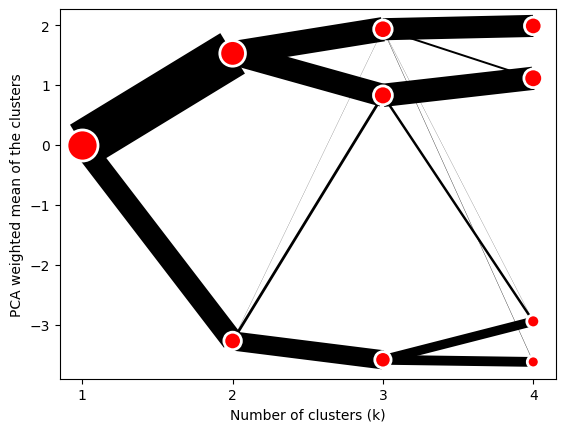

In [14]:
# 3 clusters is the way to go
cgram = Clustergram(range(1, 5))
cgram.fit(interval_data)
cgram.plot()
cgram.silhouette_score()

### Clustering 

In [15]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(interval_data)
full_interval_df_w_clusters['clusters'] = kmeans.labels_
# kmeans.cluster_centers_

In [16]:
# no diff in weekend, bigg diff in rush hour pm o v. d
# cluster 0 is rush hour Rush Hour AM/late night origin, Rush Hour Destination
# cluster 1 is evening/rush hour PM origin, Rush Hour AM destination
round(full_interval_df_w_clusters.groupby('clusters').median(),2)
# 0 is residential/attraction area
# 1 is job center

Origin_ratio_diff                                              \
time_interval           Evening Late Night Midday Rush Hour AM Rush Hour PM   
clusters                                                                      
0                         -0.01       0.02   0.01         0.02        -0.03   
1                          0.04      -0.06  -0.03        -0.10         0.13   

                      Destination_ratio_diff                                 \
time_interval Weekend                Evening Late Night Midday Rush Hour AM   
clusters                                                                      
0               -0.01                   0.01        0.0  -0.01        -0.01   
1                0.02                  -0.04        0.0   0.06         0.07   

                                    
time_interval Rush Hour PM Weekend  
clusters                            
0                     0.03    0.00  
1                    -0.10    0.02

In [17]:
# full_interval_df_w_clusters[full_interval_df_w_clusters['clusters']==0]

In [18]:
full_interval_df_w_clusters[full_interval_df_w_clusters['clusters']==1].iloc[0:15]

Origin_ratio_diff                    \
time_interval                              Evening Late Night Midday   
Station Complex Name                                                   
1 Av (L)                                      0.08      -0.06  -0.03   
103 St (6)                                    0.01      -0.04   0.01   
116 St-Columbia University (1)                0.05      -0.08  -0.02   
125 St (1)                                    0.04      -0.05   0.00   
125 St (2,3)                                  0.02      -0.05   0.01   
125 St (4,5,6)                                0.02      -0.02  -0.01   
125 St (A,C,B,D)                              0.03      -0.04   0.00   
14 St (A,C,E)/8 Av (L)                        0.09      -0.06  -0.07   
14 St (F,M,1,2,3)/6 Av (L)                    0.08      -0.06  -0.05   
14 St-Union Sq (L,N,Q,R,W,4,5,6)              0.09      -0.06  -0.06   
149 St-Grand Concourse (2,4,5)                0.02       0.00  -0.01   
161 St-Yankee Stadium (B,D,4)                 0.11       0.00  -0.05   
168 St (A,C,1)                                0.01      -0.04  -0.02   
18 St (1)                                     0.06      -0.07  -0.03   
2 Av (F)                                      0.10      -0.04  -0.06   

                                                                    \
time_interval                    Rush Hour AM Rush Hour PM Weekend   
Station Complex Name                                                 
1 Av (L)                                -0.07         0.08    0.03   
103 St (6)                              -0.04         0.10   -0.01   
116 St-Columbia University (1)          -0.14         0.20    0.00   
125 St (1)                              -0.08         0.11    0.01   
125 St (2,3)                            -0.07         0.09    0.03   
125 St (4,5,6)                          -0.04         0.07    0.01   
125 St (A,C,B,D)                        -0.06         0.07    0.03   
14 St (A,C,E)/8 Av (L)                  -0.15         0.15    0.05   
14 St (F,M,1,2,3)/6 Av (L)              -0.12         0.12    0.04   
14 St-Union Sq (L,N,Q,R,W,4,5,6)        -0.13         0.15    0.04   
149 St-Grand Concourse (2,4,5)          -0.06         0.07   -0.01   
161 St-Yankee Stadium (B,D,4)           -0.06        -0.01    0.04   
168 St (A,C,1)                          -0.07         0.16   -0.01   
18 St (1)                               -0.11         0.14    0.03   
2 Av (F)                                -0.09         0.04    0.07   

                                 Destination_ratio_diff                    \
time_interval                                   Evening Late Night Midday   
Station Complex Name                                                        
1 Av (L)                                           0.00      -0.01   0.00   
103 St (6)                                        -0.02       0.03   0.02   
116 St-Columbia University (1)                    -0.02       0.00   0.10   
125 St (1)                                         0.01       0.00   0.04   
125 St (2,3)                                      -0.01       0.01   0.04   
125 St (4,5,6)                                    -0.02       0.04   0.02   
125 St (A,C,B,D)                                   0.00       0.01   0.02   
14 St (A,C,E)/8 Av (L)                            -0.04       0.00   0.09   
14 St (F,M,1,2,3)/6 Av (L)                        -0.04      -0.01   0.06   
14 St-Union Sq (L,N,Q,R,W,4,5,6)                  -0.05      -0.01   0.08   
149 St-Grand Concourse (2,4,5)                    -0.02       0.04   0.02   
161 St-Yankee Stadium (B,D,4)                     -0.02       0.00   0.00   
168 St (A,C,1)                                    -0.01       0.04   0.04   
18 St (1)                                         -0.05      -0.02   0.08   
2 Av (F)                                          -0.01      -0.01   0.01   

                                                                   clusters  
time_inter

## Cluster based on total ridership counts 

In [19]:
full_interval_ridership_df_w_clusters = full_interval_df.drop(columns=['Estimated Average Ridership - Origin - Total'
                                                   , 'Origin Interval Ridership Ratio'
                                                   , 'Estimated Average Ridership - Destination - Total'
                                                   , 'Destination Interval Ridership Ratio'])

In [20]:
full_interval_ridership_df_w_clusters = full_interval_ridership_df_w_clusters.pivot(index='Station Complex Name', columns='time_interval'
                       , values=['Estimated Average Ridership - Origin', 'Estimated Average Ridership - Destination'])


In [21]:
full_interval_ridership_df_w_clusters

Estimated Average Ridership - Origin                \
time_interval                                        Evening    Late Night   
Station Complex Name                                                         
1 Av (L)                                        14126.571429   4824.857143   
103 St (1)                                       3845.714286   1853.285714   
103 St (6)                                       2531.857143   2630.571429   
103 St (C,B)                                     1062.142857    904.000000   
103 St-Corona Plaza (7)                          4930.857143  23867.142857   
...                                                      ...           ...   
Woodhaven Blvd (J,Z)                              344.714286    812.000000   
Woodhaven Blvd (M,R)                             3681.428571   9591.428571   
Woodlawn (4)                                     1357.857143   4929.285714   
York St (F)                                      6677.571429   1619.571429   
Zerega Av (6)                                     302.571429   1592.285714   

                                                                   \
time_interval                  Midday  Rush Hour AM  Rush Hour PM   
Station Complex Name                                                
1 Av (L)                 24589.571429  12870.000000  34197.000000   
103 St (1)               14639.714286   7945.571429  13625.142857   
103 St (6)               11613.714286   6718.142857  15197.571429   
103 St (C,B)              5515.142857   3589.428571   5261.000000   
103 St-Corona Plaza (7)  28260.000000  25854.000000  18662.714286   
...                               ...           ...           ...   
Woodhaven Blvd (J,Z)      1681.428571   1291.285714   1428.714286   
Woodhaven Blvd (M,R)     19430.285714  15963.142857  16042.142857   
Woodlawn (4)              5134.857143   5289.285714   4797.000000   
York St (F)              13130.000000   5092.142857  23920.857143   
Zerega Av (6)             2251.285714   2254.000000   1733.857143   

                                       \
time_interval                 Weekend   
Station Complex Name                    
1 Av (L)                 21236.428571   
103 St (1)                9452.714286   
103 St (6)                6711.285714   
103 St (C,B)              4084.857143   
103 St-Corona Plaza (7)  19177.142857   
...                               ...   
Woodhaven Blvd (J,Z)       621.857143   
Woodhaven Blvd (M,R)     12760.571429   
Woodlawn (4)              3708.714286   
York St (F)              15145.857143   
Zerega Av (6)             1094.000000   

                        Estimated Average Ridership - Destination  \
time_interval                                             Evening   
Station Complex Name                                                
1 Av (L)                                             10994.857143   
103 St (1)                                            6559.285714   
103 St (6)                                            3782.000000   
103 St (C,B)                                          2613.428571   
103 St-Corona Plaza (7)                              15425.142857   
...                                                           ...   
Woodhaven Blvd (J,Z)                                   599.428571   
Woodhaven Blvd (M,R)                                  7827.714286   
Woodlawn (4)                                          2071.285714   
York St (F)                                           3892.142857   
Zerega Av (6)                                          892.142857   

                                                                  \
time_interval             Late Night        Midday  Rush Hour AM   
Station Complex Name                                               
1 Av (L)                 7014.571429  22807.000000  12918.857143   
103 St (1)               2815.285714  10718.285714   4526.571429   
103 St (6)               4735.285714  10120.428571   8462.000000   
103 St (C,B)  

In [22]:
interval_ridership_data = scale(full_interval_df.pivot(index='Station Complex Name', columns='time_interval'
                       , values=['Estimated Average Ridership - Origin', 'Estimated Average Ridership - Destination']))

### Number of Clusters

K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.003 seconds.
K=3 fitted in 0.006 seconds.
K=4 fitted in 0.003 seconds.


2    0.806576
3    0.641403
4    0.548348
Name: silhouette_score, dtype: float64

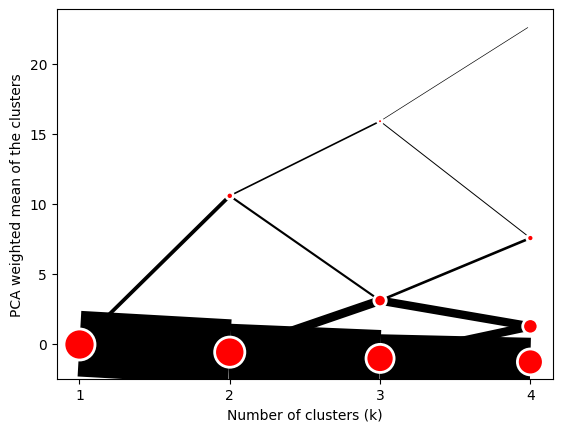

In [23]:
# 3 clusters
cgram2 = Clustergram(range(1, 5))
cgram2.fit(interval_ridership_data)
cgram2.plot()
cgram2.silhouette_score()

### Clustering

In [24]:
kmeans2 = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(interval_ridership_data)
full_interval_ridership_df_w_clusters['clusters'] = kmeans2.labels_.astype(str)
full_interval_ridership_df_w_clusters['clusters'] = full_interval_ridership_df_w_clusters['clusters'].replace({'0': 'low ridership'
                                                                                                                     ,'1': 'high ridership'
                                                                                                                      , '2': 'medium ridership'})
# kmeans.cluster_centers_

In [25]:
round(full_interval_ridership_df_w_clusters.groupby('clusters').median())

Estimated Average Ridership - Origin                      \
time_interval                               Evening Late Night   Midday   
clusters                                                                  
high ridership                              25839.0    10438.0  48485.0   
low ridership                                1307.0     2365.0   6804.0   

                                                   \
time_interval  Rush Hour AM Rush Hour PM  Weekend   
clusters                                            
high ridership      20346.0      98326.0  46294.0   
low ridership        4784.0       5855.0   4326.0   

               Estimated Average Ridership - Destination                      \
time_interval                                    Evening Late Night   Midday   
clusters                                                                       
high ridership                                   14670.0    18257.0  67651.0   
low ridership                                     2744.0     1840.0   4989.0   

                                                   
time_interval  Rush Hour AM Rush Hour PM  Weekend  
clusters                                           
high ridership      42360.0      61021.0  48788.0  
low ridership        2248.0       9657.0   4311.0

## Union of two clusters

In [26]:
cluster_combo_df = full_interval_df_w_clusters.reset_index()[[('Station Complex Name','')
                                                              ,('clusters','') ]].merge(
                    full_interval_ridership_df_w_clusters.reset_index()[[('Station Complex Name','')
                                                                        ,('clusters','') ]]
                    , on='Station Complex Name'
)   
cluster_combo_df = cluster_combo_df.drop(columns=['Station Complex Name'])
cluster_combo_df.columns = ['Station Complex Name', 'ridership_ratio_clusters', 'total_ridership_clusters'] 
cluster_combo_df['combo_cluster'] = [str(cluster_combo_df['ridership_ratio_clusters'][idx]) + '-' + 
                                     cluster_combo_df['total_ridership_clusters'][idx]
                                    for idx in range(len(cluster_combo_df))]  

/var/folders/8x/kvnrx4697fv2091hzl57dkbr0000gn/T/ipykernel_21749/369055506.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ,('clusters','') ]].merge(


In [27]:
# Most for each ratio cluster:
#  1- high riderhip, 2-medium, 0-low
cluster_combo_df['combo_cluster'].value_counts(normalize=True, ascending=True)

combo_cluster
0-high ridership    0.004717
1-high ridership    0.049528
1-low ridership     0.268868
0-low ridership     0.676887
Name: proportion, dtype: float64

In [31]:
# 0 is residential/attraction area
# 1 is evenly balanced b/n o-d
# 2 is job center
cluster_combo_df[cluster_combo_df['combo_cluster']=='1-low ridership']

,Station Complex Name,ridership_ratio_clusters,total_ridership_clusters,combo_cluster
0,1 Av (L),1,low ridership,1-low ridership
2,103 St (6),1,low ridership,1-low ridership
14,116 St-Columbia University (1),1,low ridership,1-low ridership
16,125 St (1),1,low ridership,1-low ridership
17,"125 St (2,3)",1,low ridership,1-low ridership
...,...,...,...,...
409,"W 8 St-NY Aquarium (F,Q)",1,low ridership,1-low ridership
410,WTC Cortlandt (1),1,low ridership,1-low ridership
412,"Wall St (2,3)",1,low ridership,1-low ridership
413,"Wall St (4,5)",1,low ridership,1-low ridership
